In [1]:
# Импорты и базовые настройки эксперимента.

# - Фиксируем RANDOM_STATE, чтобы случайные компоненты были воспроизводимыми.
# - Создаём папку artifacts/ – туда будем складывать результаты и модель.

from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

FIGURES_DIR = ARTIFACTS_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# Вспомогательные функции для эксперимента.

# Здесь нет “обучения” – только сервисные вещи:
# - compute_metrics: считает метрики (accuracy, F1, ROC-AUC при наличии вероятностей)
# - evaluate_on_test: единообразная оценка модели на тесте
# - save_json: аккуратное сохранение артефактов
# - plot_confusion / plot_roc: быстрая диагностика качества

def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_confusion(y_true, y_pred, title: str, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    if save_path:
      plt.savefig(save_path)
    plt.show()

def plot_roc(model, X_test, y_test, title: str, save_path=None):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    if save_path:
      plt.savefig(save_path)
    plt.show()

Загрузка данных и первичный анализ

In [3]:
data = pd.read_csv('S06-hw-dataset-01.csv')

In [4]:
print("Форма X:", data.shape)
print("Названия признаков:", list(data.columns)[:-1])

display(data.head()) # первые строки датасета

Форма X: (12000, 30)
Названия признаков: ['id', 'num01', 'num02', 'num03', 'num04', 'num05', 'num06', 'num07', 'num08', 'num09', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'num24', 'cat_contract', 'cat_region', 'cat_payment', 'tenure_months']


,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,...,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,...,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,...,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,...,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,...,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             12000 non-null  int64  
 1   num01          12000 non-null  float64
 2   num02          12000 non-null  float64
 3   num03          12000 non-null  float64
 4   num04          12000 non-null  float64
 5   num05          12000 non-null  float64
 6   num06          12000 non-null  float64
 7   num07          12000 non-null  float64
 8   num08          12000 non-null  float64
 9   num09          12000 non-null  float64
 10  num10          12000 non-null  float64
 11  num11          12000 non-null  float64
 12  num12          12000 non-null  float64
 13  num13          12000 non-null  float64
 14  num14          12000 non-null  float64
 15  num15          12000 non-null  float64
 16  num16          12000 non-null  float64
 17  num17          12000 non-null  float64
 18  num18 

In [6]:
data.describe()

,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.013705,-0.005278,-0.002357,0.038404,-0.006301,-0.865297,-0.702877,-0.290694,-0.008154,...,-0.323083,-1.314833,0.319798,-0.002742,0.027459,0.988750,1.990167,1.506833,36.083833,0.323417
std,3464.24595,2.096534,3.544498,1.004417,2.087318,1.007329,3.888966,1.989513,3.455981,0.996677,...,2.167066,3.731384,2.223649,0.996454,1.882359,0.815687,1.411643,1.121558,25.061218,0.467800
min,1.00000,-8.155181,-14.605579,-4.374043,-7.753301,-3.999332,-15.238402,-7.377252,-13.853627,-3.794637,...,-8.371050,-14.249204,-8.638879,-3.532093,-7.923990,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,-1.423844,-2.303772,-0.685618,-1.374579,-0.676552,-3.532054,-2.064888,-2.597019,-0.683959,...,-1.808969,-3.863063,-1.097700,-0.676150,-1.110822,0.000000,1.000000,0.000000,17.000000,0.000000
50%,6000.50000,-0.047565,0.053348,-0.009186,0.038766,-0.003728,-1.092517,-0.795907,-0.208245,-0.020883,...,-0.383940,-1.393400,0.431804,0.006297,0.279689,1.000000,2.000000,2.000000,30.000000,0.000000
75%,9000.25000,1.422676,2.335937,0.671441,1.484417,0.669269,1.526389,0.522625,2.093169,0.666959,...,1.125140,1.116111,1.853491,0.657478,1.363896,2.000000,3.000000,3.000000,49.000000,1.000000
max,12000.00000,8.610863,16.299709,3.651692,7.571965,4.562115,16.223054,8.006444,13.030011,3.976868,...,7.957847,15.937281,8.102095,3.707905,7.549514,2.000000,4.000000,3.000000,120.000000,1.000000


In [7]:
data.isna().mean()

id               0.0
num01            0.0
num02            0.0
num03            0.0
num04            0.0
num05            0.0
num06            0.0
num07            0.0
num08            0.0
num09            0.0
num10            0.0
num11            0.0
num12            0.0
num13            0.0
num14            0.0
num15            0.0
num16            0.0
num17            0.0
num18            0.0
num19            0.0
num20            0.0
num21            0.0
num22            0.0
num23            0.0
num24            0.0
cat_contract     0.0
cat_region       0.0
cat_payment      0.0
tenure_months    0.0
target           0.0
dtype: float64

In [8]:
data.duplicated().value_counts(normalize=True)

False    1.0
Name: proportion, dtype: float64

In [9]:
data.target.value_counts(normalize=True)

target
0    0.676583
1    0.323417
Name: proportion, dtype: float64

In [10]:
X = data.iloc[:, 1:-1]       # матрица признаков
display(X.head())
y = data.target     # таргет default: (0/1)
display(y.head())
feature_names = list(X.columns)

,num01,num02,num03,num04,num05,num06,num07,num08,num09,num10,...,num19,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months
0,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,-0.417059,...,0.150213,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33
1,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,-1.122641,...,1.955462,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102
2,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,-0.477243,...,-0.573642,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3
3,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,1.149337,...,1.809714,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50
4,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,1.113718,...,0.289182,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81


0    0
1    1
2    0
3    0
4    0
Name: target, dtype: int64

Train/Test-сплит и воспроизводимость

In [11]:
# Отделяем тестовую выборку (20% данных)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("Размеры выборок:")
print("  train:", X_train.shape)
print("  test: ", X_test.shape)

print("\nРаспределение классов (train):")
print(y_train.value_counts(normalize=True))
print("\nРаспределение классов (test):")
print(y_test.value_counts(normalize=True))

Размеры выборок:
  train: (9600, 28)
  test:  (2400, 28)

Распределение классов (train):
target
0    0.676562
1    0.323437
Name: proportion, dtype: float64

Распределение классов (test):
target
0    0.676667
1    0.323333
Name: proportion, dtype: float64


Фиксированный seed необходим для воспроизводимости эксперимента, чтобы при повторном запуске образовались такие же выборки.

Стратификация важна, особенно при сильном дисбалансе классов, как в нашем примере (95% к 5%). Чтобы в обучающей и тестовой выборках встречались классы в таких же пропорциях что и изначально.

Baseline’ы

In [12]:
# - results: список словарей с метриками на тесте
# - best_models: сюда складываем обученные лучшие модели (чтобы потом их диагностировать/сохранить)
# - search_summaries: сюда складываем лучшие параметры подбора и CV-оценку
results = []
best_models = {}
search_summaries = {}

# Dummy baseline (без подбора)

dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, X_test, y_test, "Dummy(most_frequent)"))
best_models["Dummy(most_frequent)"] = dummy
print(results[0])

{'accuracy': 0.6766666666666666, 'f1': 0.0, 'roc_auc': 0.5, 'model': 'Dummy(most_frequent)'}


accuracy совпадает с долей самого частого класса

In [13]:
# LogisticRegression baseline (с минимальным подбором)

# Логрегрессия почти всегда требует масштабирования признаков, поэтому используем Pipeline со StandardScaler.
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
])


# Подбираем C (обратная сила регуляризации): меньше C -> сильнее регуляризация -> проще модель.
lr_grid = {
    "lr__C": [0.1, 1.0, 10.0],
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"],
}

# CV = кросс-валидация на train: нужна для подбора гиперпараметров без доступа к тесту.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearchCV перебирает сетку параметров и оценивает качество по CV. scoring=roc_auc – метрика для бинарной классификации по вероятностям.
lr_search = GridSearchCV(
    lr, lr_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)"))

print(search_summaries["LogReg(scaled)"])
print(results[1])

{'best_params': {'lr__C': 1.0, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}, 'best_cv_roc_auc': 0.8822403954980853}
{'accuracy': 0.8275, 'f1': 0.7076271186440678, 'roc_auc': 0.8746905312071505, 'model': 'LogReg(scaled)'}


C:\Users\user\Desktop\уник\5сем\kuznetsova-ms-aie\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


accuracy и roc auc лучше, чем у Dummy, но дальнейшие модели должны преодолеть этот погор качества.

Модели недели 6

In [14]:
# Единая функция для подбора гиперпараметров через GridSearchCV.

# Она:
# - обучает GridSearchCV на X_train/y_train
# - кладёт лучшую модель и summary в словари
# - добавляет финальную оценку на тесте в results

def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [15]:
# 3.1 Decision Tree
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_grid = {
    "max_depth": [None, 3, 5, 8],
    "min_samples_leaf": [1, 5, 10, 20],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}

dt_search = run_search("DecisionTree", dt, dt_grid)
print(search_summaries["DecisionTree"])
print(results[2])

{'best_params': {'ccp_alpha': 0.0, 'max_depth': None, 'min_samples_leaf': 20}, 'best_cv_roc_auc': 0.9183278602765164}
{'accuracy': 0.8691666666666666, 'f1': 0.7942332896461337, 'roc_auc': 0.9097569162307654, 'model': 'DecisionTree'}


In [16]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)

rf_grid = {
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", 0.5],
}

rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

{'best_params': {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1},
 'best_cv_roc_auc': 0.9691355545390421}

In [17]:
# HistGradientBoosting
hgb = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True
)

hgb_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, None],
    "max_leaf_nodes": [15, 31, 63],
}

hgb_search = run_search("HistGradientBoosting", hgb, hgb_grid)
search_summaries["HistGradientBoosting"]

{'best_params': {'learning_rate': 0.1,
  'max_depth': None,
  'max_leaf_nodes': 63},
 'best_cv_roc_auc': 0.9733385894513183}

StackingClassifier

In [18]:
# Stacking (опционально): ансамбль из нескольких уже обученных моделей + метамодель.

# - estimators: базовые модели (их предсказания идут на вход метамодели)
# - final_estimator: метамодель (здесь логистическая регрессия)
# - cv=5: CV внутри стекинга, чтобы метамодель училась без утечки

estimators = [
    ("lr", best_models["LogReg(scaled)"]),
    ("rf", best_models["RandomForest"]),
    ("hgb", best_models["HistGradientBoosting"]),
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Стекинг обычно имеет мало “ручек”, поэтому без GridSearch – просто честная оценка
stack.fit(X_train, y_train)
best_models["Stacking"] = stack
results.append(evaluate_on_test(stack, X_test, y_test, "Stacking"))

{"note": "stacking fitted"}

{'note': 'stacking fitted'}

Сводка результатов (test)

In [19]:
df = pd.DataFrame(results)

# сортировка: roc_auc (если есть) иначе accuracy
df_sorted = df.copy()
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])

df_sorted

,accuracy,f1,roc_auc,model
4,0.933750,0.893645,0.972740,HistGradientBoosting
5,0.935833,0.898013,0.970780,Stacking
3,0.925833,0.879240,0.966576,RandomForest
2,0.869167,0.794233,0.909757,DecisionTree
1,0.827500,0.707627,0.874691,LogReg(scaled)
0,0.676667,0.000000,0.500000,Dummy(most_frequent)


Сохранение артефактов эксперимента

In [20]:
# - metrics_test.json (итоговые метрики)
# - search_summaries.json (лучшие параметры подбора)

metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

metrics_dict = df_sorted.set_index('model').to_dict(orient='index')

save_json(metrics_dict, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts\metrics_test.json
Saved: artifacts\search_summaries.json


Интерпретация лучшей модели

In [21]:
# Выбор “лучшей” модели по таблице результатов.

best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()

('HistGradientBoosting',
 {'accuracy': 0.93375,
  'f1': 0.8936454849498328,
  'roc_auc': 0.9727397668985831,
  'model': 'HistGradientBoosting'})

In [22]:
# Сохранение лучшей модели и метаданных.

# - best_model.joblib: сериализованная модель
# - best_model_meta.json: “паспорт” результата (какая модель, какие метрики, какие параметры)

model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

print("Saved:", model_path)
print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")

Saved: artifacts\best_model.joblib
Saved: artifacts\best_model_meta.json


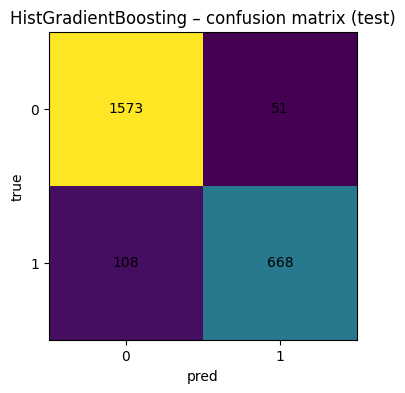

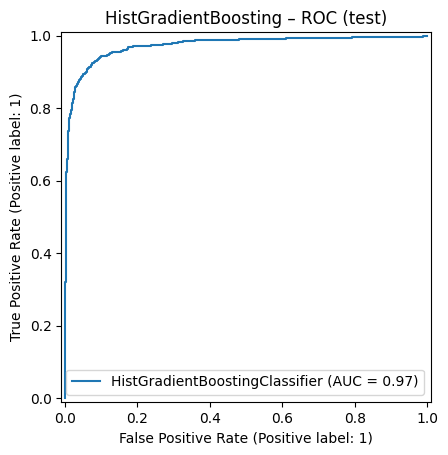

In [23]:
# Диагностика на тесте: confusion matrix и ROC-кривая.

# Confusion matrix помогает понять тип ошибок (FP/FN),
# ROC показывает качество ранжирования вероятностей по всем порогам.

y_pred = best_model.predict(X_test)
confusion_path = FIGURES_DIR / "confusion_matrix.png"
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)", save_path=confusion_path)
roc_path = FIGURES_DIR / "roc_auc_curve.png"
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)", save_path=roc_path)

Интерпретация: permutation importance (top‑15)

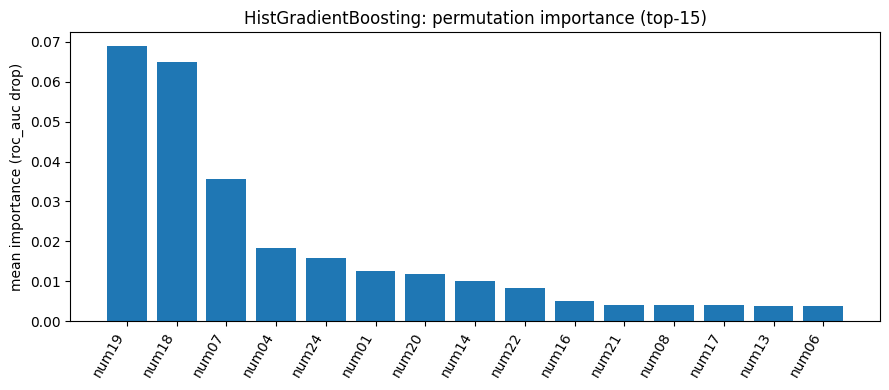

In [24]:
scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "permutation_importance.png")
plt.show()

больше всего влияют признаки num19 и num18, также достаточно большой вклад вносить признак num07